In [2]:

import pandas as pd
import geopandas as gpd
import glob
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns

import os
from pathlib import Path
from tqdm import tqdm

In [3]:
# Directories
current_dir = Path(os.getcwd())
data_folder = current_dir / 'datos'
figure_folder = current_dir / 'figures'
figures_absolute_folder = current_dir / 'figures_absolute'


### Merge Data

In [4]:
stats_basicas = str(data_folder / 'eimri_estadistica_basica_provincias_{year}.csv')
stats_freq = str(data_folder / 'eimri_frecuencias_provincias_{year}.csv')

# Get a list of all files matching the pattern
files = glob.glob(stats_basicas.format(year='*'))

# Initialize an empty dataframe to store the merged data
merged_df = pd.DataFrame()

# Iterate over each file and merge it with the existing dataframe
for file in files:
    df = pd.read_csv(file, sep=';', encoding='latin-1')
    df['year'] = file.split('_')[-1].split('.')[0]  # Extract the year from the filename
    merged_df = pd.concat([merged_df, df])


# save to disk
merged_fp = str(data_folder / 'eimri_estadistica_basica_all.csv')
# merged_df.to_csv(merged_fp, index=False)


### Definitions

In [5]:
# File path
merged_file = str(data_folder / 'eimri_estadistica_basica_all.csv')
gpd_file = data_folder / 'lineas_limite.zip!SHP_ETRS89/provincias'


In [6]:
## Load data
## ---------
# gpd.read_file('/home/alefuag/code/miarfid/vdd/Spain_shapefile.zip')

provincias = gpd.read_file(gpd_file)
fwi_df = pd.read_csv(merged_file)

## Clean data
## ----------

def clean_province_name(province):
    clean_name = unidecode(province)
    if '/' in clean_name:
        return clean_name.split('/')[1]
    return clean_name


fwi_prov = fwi_df['Provincia'].apply(clean_province_name).replace('Araba', 'Alava')
geo_prov = provincias['NAMEUNIT'].apply(clean_province_name)

# calculate the intersection between the two lists
common_provinces = set(fwi_prov.unique()).intersection(set(geo_prov.unique()))

zip_prov = list(zip(
    filter(lambda x: x in common_provinces, fwi_prov.unique()),
    filter(lambda x: x in common_provinces, geo_prov.unique())
    ))

len(zip_prov)

48

### Merge data

In [7]:
fwi_df_clean = fwi_df[fwi_df['Provincia'].apply(clean_province_name).replace('Araba', 'Alava').isin(common_provinces)]
fwi_df_clean.loc[:, 'Provincia'] = fwi_df_clean['Provincia'].apply(clean_province_name).replace('Araba', 'Alava')
geo_prov_clean = provincias[provincias['NAMEUNIT'].apply(clean_province_name).isin(common_provinces)]
geo_prov_clean.loc[:, 'NAMEUNIT'] = geo_prov_clean['NAMEUNIT'].apply(clean_province_name)

geo_prov_useful_cols = ['NAMEUNIT', 'geometry']

# merge the two dataframes
merged_df = geo_prov_clean[geo_prov_useful_cols].merge(fwi_df_clean, left_on='NAMEUNIT', right_on='Provincia', how='right')

In [8]:
### Process data
### ------------

months = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre', 'Anual']

processed_df = merged_df.copy()

for m in months:
    processed_df[m] = merged_df[m].str.replace(',', '.').astype('float64')

def calculate_interval(df):
    # group by year and province, then substrac the max from the min
    return df.groupby(['year', 'Provincia']).agg({'Anual': lambda x: x.max() - x.min()}).rename(columns={'Anual': 'Intervalo'}).reset_index()

interval_df = calculate_interval(processed_df)

processed_df = processed_df.merge(interval_df, on=['year', 'Provincia'])

### Test

<Axes: >

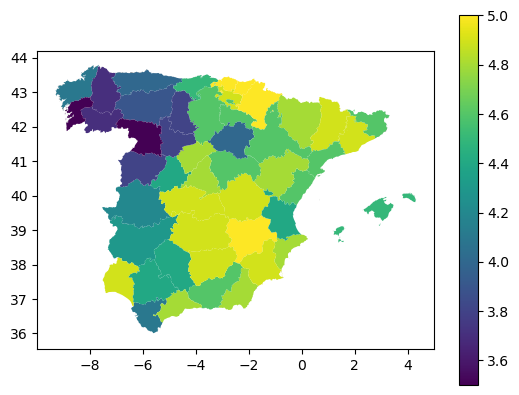

In [9]:
year = 2019 # [2019, 2020, 2021, 2022]
medida = 'Maximo' # ['Minimo', 'Cuartil_1', 'Mediana', 'Media', 'Cuartil_3', 'Maximo']
mes = 'Julio' # ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre', 'Anual']

year_mask = processed_df['year'] == year
medida_mask = processed_df['Estadisticos'] == medida

filtered_df = processed_df[year_mask & medida_mask]
filtered_df.plot(column=mes, legend=True)

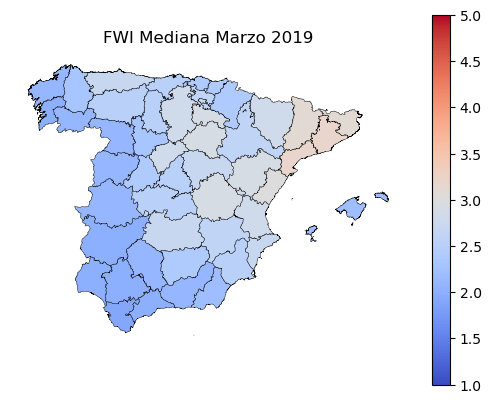

In [11]:
# write as a function

def plot_fwi(province_df, year, medida, mes, absolute=False):
    year_mask = province_df['year'] == year
    medida_mask = province_df['Estadisticos'] == medida

    filtered_df = province_df[year_mask & medida_mask]

    lower_bound = 1 if absolute else filtered_df[mes].min()
    upper_bound = 5 if absolute else filtered_df[mes].max()

    ax = filtered_df.plot(
        column=mes,
        legend=True,
        # figsize=(12, 12),
        cmap='coolwarm',
        edgecolor='black',
        linewidth=0.3,
        vmin=lower_bound, # cmap range min
        vmax=upper_bound, # cmap range max
        missing_kwds={'color': 'lightgrey'}
        )

    ax.set_title(f'FWI {medida} {mes} {year}')
    # remove axis
    ax.axis('off')

plot_fwi(
    processed_df,
    2019,
    'Mediana',
    'Marzo',
    absolute=True
    )

In [12]:
years = [2019, 2020, 2021, 2022]
medidas = ['Minimo', 'Cuartil_1', 'Mediana', 'Media', 'Cuartil_3', 'Maximo']
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre', 'Anual']

In [57]:

with tqdm(total=len(years) * len(medidas) * len(meses), desc="Normal plot") as pbar:
    for year in years:
        for medida in medidas:
            for mes in meses:
                plot_fwi(processed_df, year, medida, mes)
                fig_filepath = figure_folder / f'fwi_{year}_{medida}_{mes}.png'
                plt.savefig(fig_filepath)
                plt.close()
                pbar.update(1)

# absolute values
with tqdm(total=len(years) * len(medidas) * len(meses), desc="Absolute plot") as pbar:
    for year in years:
        for medida in medidas:
            for mes in meses:
                plot_fwi(processed_df, year, medida, mes, absolute=True)
                fig_filepath = figures_absolute_folder / f'fwi_{year}_{medida}_{mes}.png'
                plt.savefig(fig_filepath)
                plt.close()
                pbar.update(1)


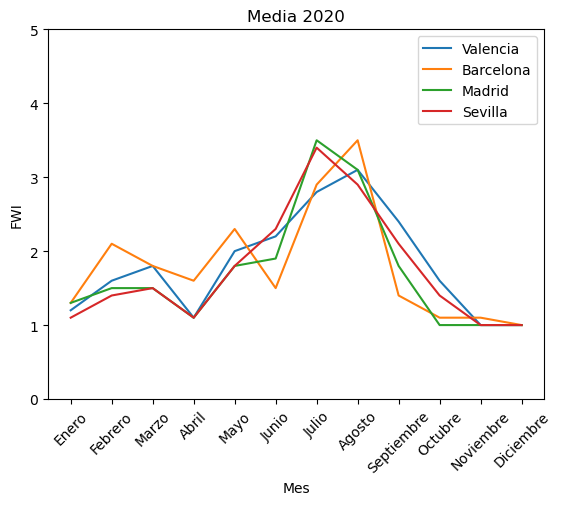

In [45]:
# lineplot de una cierta medida en una provincia a lo largo de los meses

def plot_lineplot(province_df, provincias, medida, year, absolute=False):
    year_mask = province_df['year'] == year
    medida_mask = province_df['Estadisticos'] == medida

    for provincia in provincias:
        provincia_mask = province_df['Provincia'] == provincia
        filtered_df = province_df[provincia_mask & medida_mask & year_mask]
        value_list = [filtered_df[mes].values for mes in meses[:-1]]
        # unpack the list of lists
        plt.plot(meses[:-1], value_list, label=provincia)
    
    if absolute:
        plt.ylim(0, 5)
    plt.title(f'{medida} {year}')
    plt.ylabel('FWI')
    plt.xlabel('Mes')
    # rotate x labels
    plt.xticks(rotation=45)
    plt.legend()

plot_lineplot(processed_df, ['Valencia', 'Barcelona', 'Madrid', 'Sevilla'], 'Media', 2020, absolute=True)

In [46]:

# save the lineplot
provincias = ['Valencia', 'Barcelona', 'Madrid', 'Sevilla']
years = [2019, 2020, 2021, 2022]
medidas = ['Minimo', 'Cuartil_1', 'Mediana', 'Media', 'Cuartil_3', 'Maximo']
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

In [49]:
with tqdm(total=len(medidas) * len(years), desc="Lineplot") as pbar:
    for year in years:
        for medida in medidas:
                plot_lineplot(processed_df, provincias, medida, year)
                fig_filepath = figure_folder / f'lineplot_{medida}_{year}.png'
                plt.savefig(fig_filepath)
                plt.close()
                pbar.update(1)

with tqdm(total=len(medidas) * len(years), desc="Absolute Lineplot") as pbar:
    for year in years:
        for medida in medidas:
                plot_lineplot(processed_df, provincias, medida, year, absolute=True)
                fig_filepath = figures_absolute_folder / f'lineplot_{medida}_{year}.png'
                plt.savefig(fig_filepath)
                plt.close()
                pbar.update(1)



Lineplot:   0%|          | 0/24 [00:00<?, ?it/s]

Absolute Lineplot: 100%|██████████| 24/24 [00:08<00:00,  2.85it/s]
